# Prepare dataset

In [1]:
!python --version

Python 3.10.14


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.5 MB/s eta 0:00:00


In [3]:
SEED = 42

import os
import math
import random

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f"torch version: {torch.__version__}")

torch version: 2.4.0


# Raw Dataset

In [4]:
import string

possible_categories = [letter.lower() for i, letter in enumerate(string.ascii_uppercase) if letter not in ['J', 'Z']]
#possible_categories.append("*") # unknown symbol
#possible_categories.extend([str(x) for x in range(0, 10)]) # digits 0-9

possible_categories.remove("r") # Remove "r" as the quality in the converted dataset wasn't sufficient

def load_dataset_from_csv(path, keep_every=1):
    df = pd.read_csv(path, dtype={63: str}, header=None)
    df = df[df[63].notna() & df[63].apply(lambda l: str(l).lower()).isin(possible_categories)]
    if keep_every > 1:
        df = df[df.index % keep_every == 0]
    df[63] = df[63].apply(lambda l: l.lower())
    df.columns = [f"{coord}_dominant_hand_{i}" for i in range(21) for coord in ["x", "y", "z"]] + [63]
    return df

In [5]:
DATASET_FOLDER = "/kaggle/input/tdk-v2-static"

In [6]:
import os

# Load own dataset
my_dataset = load_dataset_from_csv(os.path.join(DATASET_FOLDER, "my_dataset.csv"))

# Load mnist (converted)
mnist_df = load_dataset_from_csv(os.path.join(DATASET_FOLDER, "mnist_dataset.csv"))
mnist_df = mnist_df[mnist_df[63] != "r"] # Need to remove r as it is mainly faulty

# Load exter (converted)
exter_df = pd.DataFrame()
for p in ["A", "B", "C", "D", "E"]:
    exported_df = load_dataset_from_csv(os.path.join(DATASET_FOLDER, f"exter_{p}.csv"))
    exter_df = pd.concat([exter_df, exported_df])
exter_df = exter_df[exter_df[63] != "r"] # Need to remove r as it is mainly faulty

In [7]:
def category_distrib(df, title=""):
    category_counts = df[63].value_counts()
    plt.figure(figsize=(8, 6))
    category_counts.plot(kind='bar')
    plt.xlabel('Kategóriák', fontname="Calibri")
    plt.ylabel('Minták száma', fontname="Calibri")
    plt.title(title, fontname="Calibri")
    #plt.savefig('Distribution of training dataset Categories.png', dpi=300)  # High resolution
    plt.show()

def equalize_category_counts(df, category_column, max_size=None):
    # Group by category and find the maximum size
    if not max_size:
        max_size = df.groupby(category_column).size().min()

    # Resample each group
    resampled = [group.sample(max_size, replace=False, random_state=SEED) for _, group in df.groupby(category_column)]

    # Concatenate the resampled groups
    return pd.concat(resampled, ignore_index=True)

In [8]:
df = pd.concat([exter_df, mnist_df, my_dataset]).reset_index(drop=True)

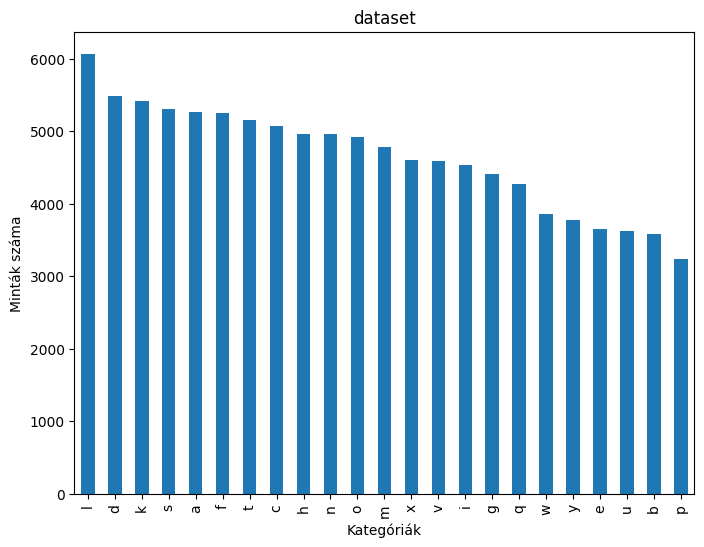

In [9]:
category_distrib(df, "dataset")

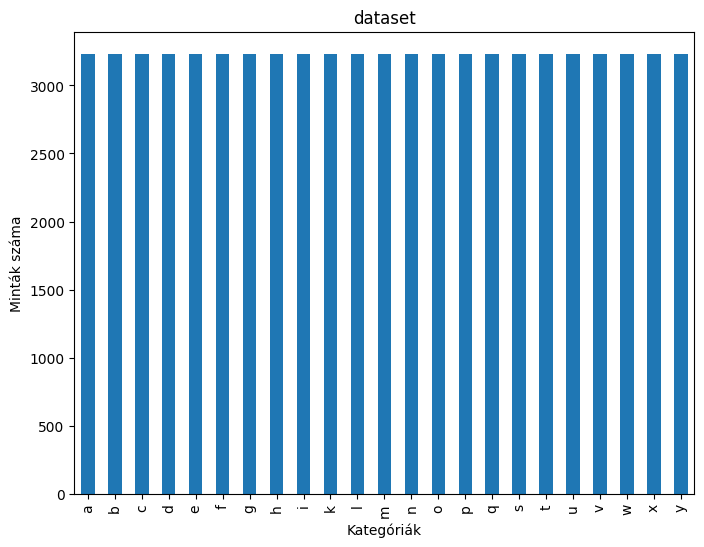

In [10]:
df = equalize_category_counts(df, 63)
category_distrib(df, "dataset")

In [11]:
df = df.sample(len(df), replace=False, random_state=SEED)
df

,x_dominant_hand_0,y_dominant_hand_0,z_dominant_hand_0,x_dominant_hand_1,y_dominant_hand_1,z_dominant_hand_1,x_dominant_hand_2,y_dominant_hand_2,z_dominant_hand_2,x_dominant_hand_3,...,x_dominant_hand_18,y_dominant_hand_18,z_dominant_hand_18,x_dominant_hand_19,y_dominant_hand_19,z_dominant_hand_19,x_dominant_hand_20,y_dominant_hand_20,z_dominant_hand_20,63
29244,0.516720,0.898206,2.388885e-06,0.313777,0.772766,-0.033415,0.296731,0.618676,-0.063025,0.428083,...,0.706178,0.555112,-0.313315,0.592088,0.633026,-0.263466,0.596579,0.690456,-0.189609,k
32320,0.752242,0.843529,3.700000e-07,0.738511,0.807791,-0.015201,0.737754,0.760241,-0.022147,0.752178,...,0.796572,0.751478,-0.030285,0.788456,0.784615,-0.028703,0.780519,0.806802,-0.022706,k
27212,0.342685,0.903137,-1.104080e-06,0.544841,0.747481,-0.055150,0.718242,0.544821,-0.079315,0.789781,...,0.174138,0.214030,-0.019928,0.181643,0.146073,0.000194,0.197853,0.109034,0.026671,i
69051,0.502115,0.647325,-1.856063e-06,0.328798,0.571366,-0.079685,0.219239,0.444155,-0.150389,0.288046,...,0.826625,0.475565,-0.307203,0.684039,0.528543,-0.260256,0.639372,0.544890,-0.191759,x
40515,0.471101,0.763630,8.760400e-07,0.625543,0.718722,-0.070818,0.772135,0.562461,-0.100401,0.792960,...,0.334026,0.346332,-0.142962,0.418023,0.428734,-0.138585,0.466464,0.520166,-0.114760,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,0.708934,0.656955,-2.041292e-06,0.468399,0.564557,-0.058104,0.385843,0.413904,-0.111199,0.540964,...,0.697645,0.302236,-0.260672,0.679888,0.409177,-0.269171,0.726932,0.471108,-0.256806,m
6265,0.717921,0.891532,4.655922e-07,0.655947,0.826175,-0.028359,0.621939,0.679053,-0.042234,0.671498,...,0.754184,0.406799,-0.070898,0.748957,0.321055,-0.083862,0.743296,0.240793,-0.096242,b
54886,0.612331,0.661212,-2.859275e-06,0.396809,0.574972,-0.062269,0.233736,0.426671,-0.101191,0.253331,...,0.786716,0.258907,-0.215409,0.717653,0.361195,-0.152247,0.738842,0.408499,-0.081043,s
860,0.440668,0.603220,-2.980000e-07,0.479031,0.562884,-0.014832,0.507349,0.482958,-0.020157,0.514548,...,0.419428,0.450595,-0.025513,0.426090,0.501262,-0.022084,0.428526,0.534141,-0.014789,a


In [12]:
num_rows_with_nan = df.isnull().any(axis=1).sum()
print(f"Number of partial hands: {num_rows_with_nan}")

Number of partial hands: 0


In [13]:
def max_distance_stretch_preprocess_features(flat_xyz: np.ndarray):
    if len(flat_xyz.shape) == 1:
        flat_xyz = np.array([flat_xyz])

    batch_dim = flat_xyz.shape[0]

    xyz = flat_xyz.reshape((batch_dim, 21, 3))

    # Take only the x and y coordinates, as z only shows relative distance
    xy = xyz[:, :, :2]
    
    centroids = xy.mean(axis=1, keepdims=True)
    centered_xy = xy - centroids
    
    max_distances = np.max(np.linalg.norm(centered_xy, axis=2), axis=1, keepdims=True)  # (batch_size, 1)
    scale_factors = 1 / max_distances
    scaled_xy = centered_xy * scale_factors[..., np.newaxis]  # (batch_size, num_points, 2)
    
    xyz = np.concatenate([scaled_xy, xyz[:, :, 2:]], axis=2)
    return xyz.reshape((batch_dim, -1))

float_xyz = df.values[0][:-1].astype(np.float32)
max_distance_stretch_preprocess_features(float_xyz)

array([[-1.59178320e-02,  9.42104936e-01,  2.38888538e-06,
        -5.03706098e-01,  6.40600204e-01, -3.34153138e-02,
        -5.44676602e-01,  2.70231813e-01, -6.30248189e-02,
        -2.28962675e-01, -3.06251515e-02, -1.21426336e-01,
         1.40278870e-02, -2.75493473e-01, -1.78345188e-01,
        -2.33824074e-01,  6.19045906e-02,  2.66353413e-02,
        -4.68948901e-01, -3.24361861e-01, -6.98049814e-02,
        -5.97596467e-01, -5.53279221e-01, -1.16222329e-01,
        -6.51685774e-01, -7.58488953e-01, -1.38556615e-01,
         1.69163719e-01,  7.01347068e-02, -3.90396789e-02,
         2.74408966e-01, -3.74452293e-01, -1.71803087e-01,
         3.07874709e-01, -6.16776466e-01, -2.45149463e-01,
         4.08896238e-01, -8.35387111e-01, -2.64918208e-01,
         5.66724002e-01,  1.59903094e-01, -1.16272345e-01,
         1.86667338e-01, -6.48950189e-02, -3.11682999e-01,
        -1.75707176e-01,  1.79485917e-01, -3.13523948e-01,
        -2.40269974e-01,  3.44392955e-01, -2.46633783e-0

In [14]:
import numpy as np

def preprocess_features(flat_xyz: np.ndarray):
    if len(flat_xyz.shape) == 1:
        flat_xyz = np.array([flat_xyz])

    batch_dim = flat_xyz.shape[0]
    xyz = flat_xyz.reshape((batch_dim, 21, 3))

    # Take only the x and y coordinates, as z only shows relative distance
    xy = xyz[:, :, :2]

    # Center the points to (0,0)
    centroids = xy.mean(axis=1, keepdims=True)
    centered_xy = xy - centroids

    # Calculate the max distance in x and y directions separately
    max_x_distances = np.max(np.abs(centered_xy[..., 0]), axis=1, keepdims=True)  # shape: (batch_dim, 1)
    max_y_distances = np.max(np.abs(centered_xy[..., 1]), axis=1, keepdims=True)  # shape: (batch_dim, 1)

    # Calculate separate scale factors for x and y directions
    scale_factors_x = 1 / max_x_distances  # shape: (batch_dim, 1)
    scale_factors_y = 1 / max_y_distances  # shape: (batch_dim, 1)

    # Scale x and y coordinates separately
    scaled_x = centered_xy[..., 0] * scale_factors_x  # shape: (batch_dim, 21)
    scaled_y = centered_xy[..., 1] * scale_factors_y  # shape: (batch_dim, 21)

    # Combine the scaled x and y coordinates
    scaled_xy = np.stack([scaled_x, scaled_y], axis=-1)  # shape: (batch_dim, 21, 2)

    # Concatenate back the z-coordinates (without scaling) to retain depth info
    xyz = np.concatenate([scaled_xy, xyz[:, :, 2:]], axis=2)
    return xyz.reshape((batch_dim, -1))

# Example usage with float_xyz
float_xyz = df.values[0][:-1].astype(np.float32)
preprocessed_xyz = preprocess_features(float_xyz)
preprocessed_xyz

array([[-1.67062711e-02,  1.00000000e+00,  2.38888538e-06,
        -5.28655589e-01,  6.79966927e-01, -3.34153138e-02,
        -5.71655393e-01,  2.86838353e-01, -6.30248189e-02,
        -2.40303606e-01, -3.25071551e-02, -1.21426336e-01,
         1.47227133e-02, -2.92423368e-01, -1.78345188e-01,
        -2.45405793e-01,  6.57088086e-02,  2.66353413e-02,
        -4.92176801e-01, -3.44294846e-01, -6.98049814e-02,
        -6.27196491e-01, -5.87279797e-01, -1.16222329e-01,
        -6.83964968e-01, -8.05100322e-01, -1.38556615e-01,
         1.77542701e-01,  7.44446889e-02, -3.90396789e-02,
         2.88000941e-01, -3.97463471e-01, -1.71803087e-01,
         3.23124290e-01, -6.54679179e-01, -2.45149463e-01,
         4.29149598e-01, -8.86724114e-01, -2.64918208e-01,
         5.94794869e-01,  1.69729605e-01, -1.16272345e-01,
         1.95913315e-01, -6.88830093e-02, -3.11682999e-01,
        -1.84410274e-01,  1.90515861e-01, -3.13523948e-01,
        -2.52170980e-01,  3.65556926e-01, -2.46633783e-0

In [16]:
# regular_connections = [(0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
#                             (5,6), (5,9), (6,7), (7,8), (9,10), (9,13), 
#                             (10,11), (11,12), (13,14), (13,17), (14,15), 
#                             (15,16), (17,18), (18,19), (19,20)]

# inverse_graph_connections = []
# for i in range(21):
#     for j in range(21):
#         conn = (i, j)
#         if conn not in regular_connections and i != j:
#             inverse_graph_connections.append(conn)

In [32]:
from typing import List
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data, InMemoryDataset

class GraphDataset(InMemoryDataset):
    def __init__(self, df: pd.DataFrame, transform=None, pre_transform=None):
        self.label_encoder = LabelEncoder()
        self.connections = [(0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
                            (5,6), (5,9), (6,7), (7,8), (9,10), (9,13), 
                            (10,11), (11,12), (13,14), (13,17), (14,15), 
                            (15,16), (17,18), (18,19), (19,20)]

        super().__init__(None, transform, pre_transform)
        self.data_list = self.process_data(df)

    def process_data(self, df: pd.DataFrame) -> List[Data]:
        # Encode the categorical column
        labels = self.label_encoder.fit_transform(df.iloc[:, -1])
        features = preprocess_features(df.values[:, :-1].astype(np.float32)).reshape((len(df), 21,3))

        # Create the edge list and make it undirected by adding reverse connections (same for all graphs)
        edges = []
        for a, b in self.connections:
            edges.append([a, b])
            edges.append([b, a])  # Add the reverse connection
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        data_list = []
        for feature, label in zip(features, labels):
            # Create the graph data object
            x = torch.tensor(feature, dtype=torch.float)
            y = torch.tensor(label, dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        return data_list
    
    @property
    def num_classes(self):
        return len(set(self.label_encoder.classes_))

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [33]:
dataset = GraphDataset(df)

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: GraphDataset(74359):
Number of graphs: 74359
Number of features: 2
Number of classes: 23

Data(x=[21, 2], edge_index=[2, 42], y=9)
Number of nodes: 21
Number of edges: 42
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


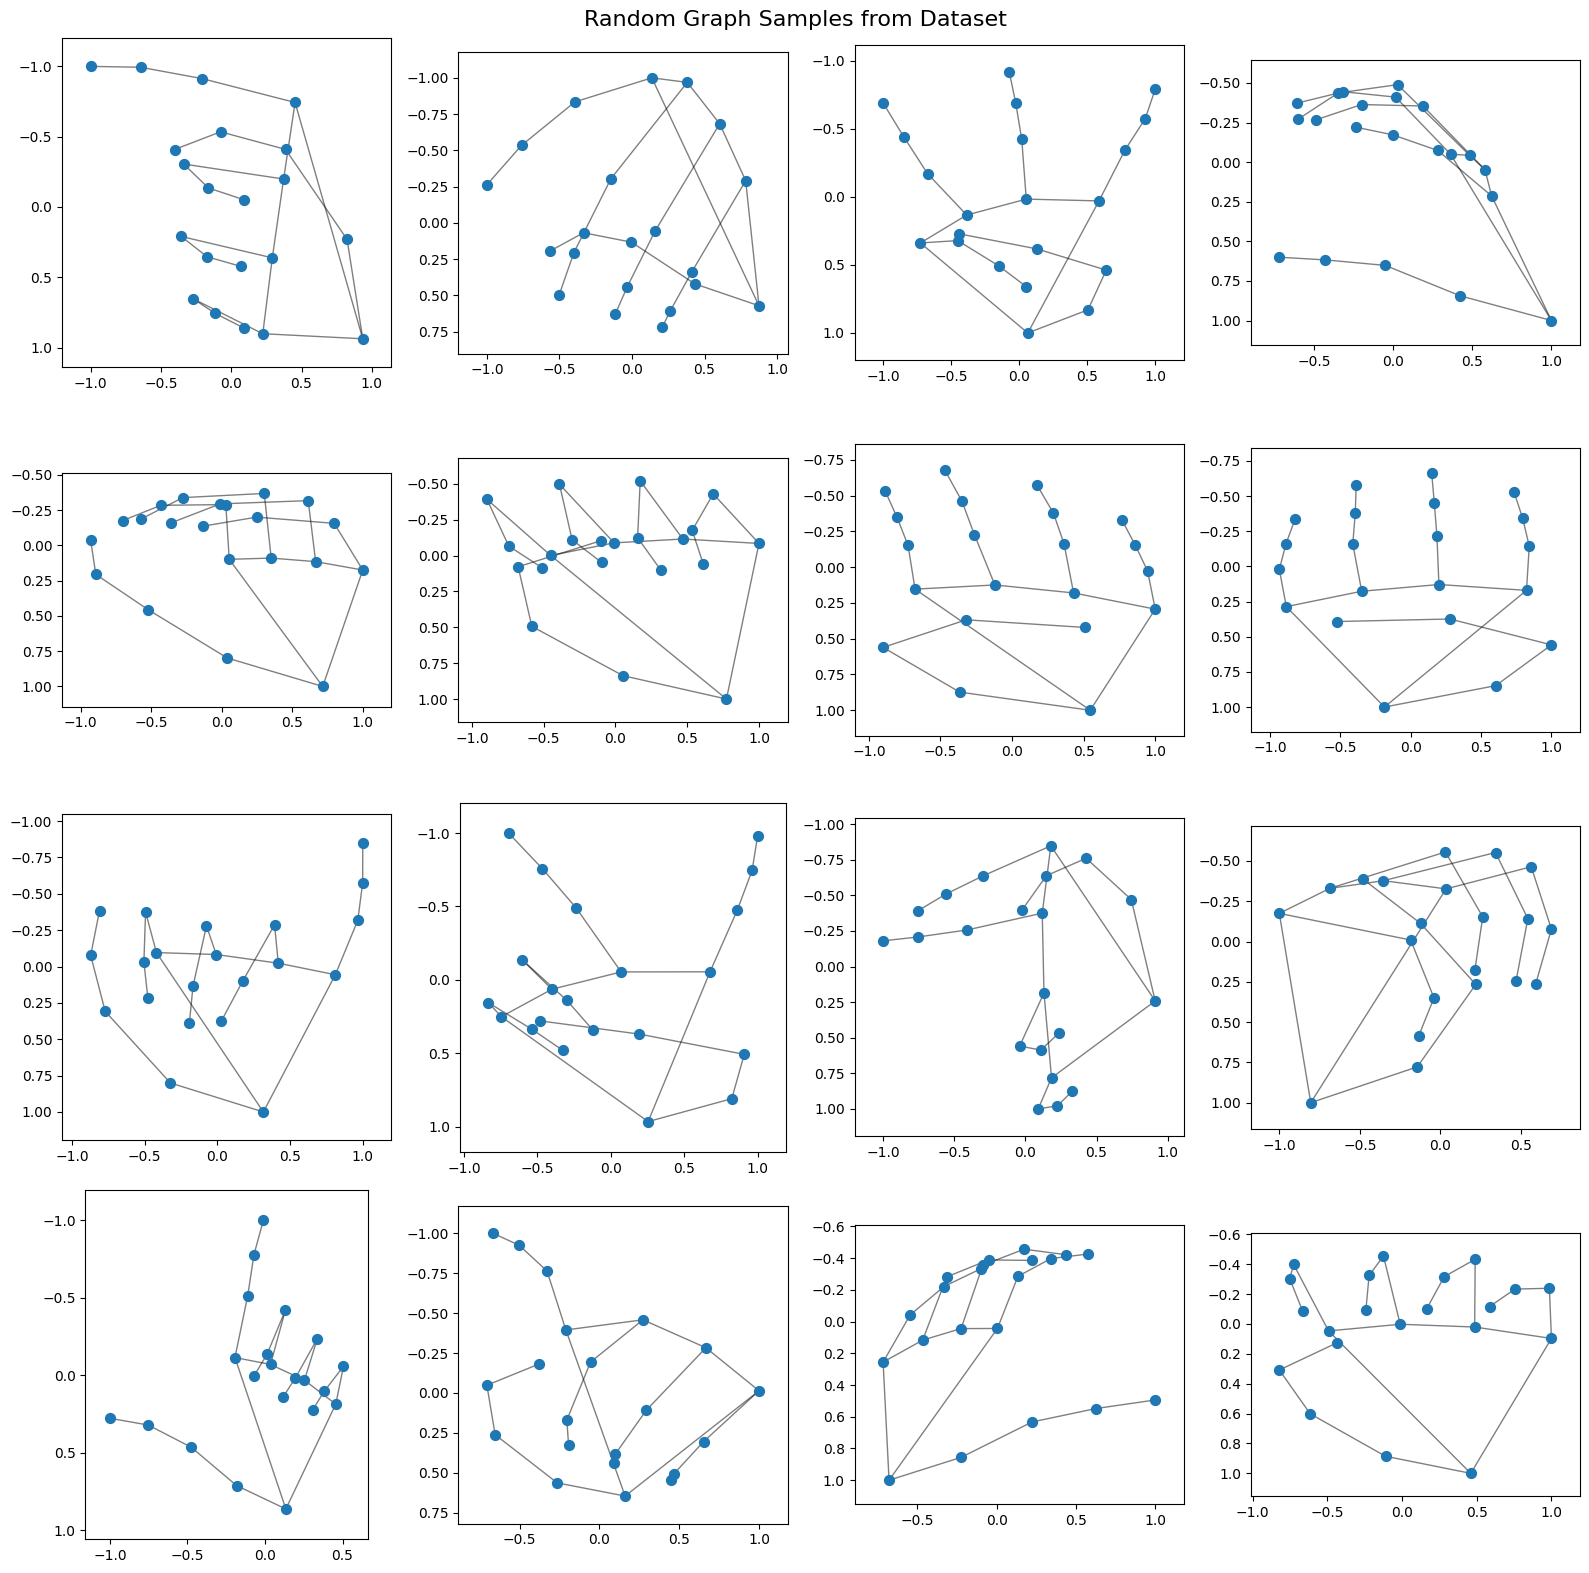

In [34]:
import networkx as nx

def visualize_graph_grid(dataset, grid_size=4):
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(4 * grid_size, 4 * grid_size))
    fig.suptitle("Random Graph Samples from Dataset", fontsize=16)

    # Select random samples from the dataset
    random_indices = random.sample(range(len(dataset)), grid_size * grid_size)

    for idx, ax in zip(random_indices, axs.flatten()):
        data = dataset[idx]
        node_features = data.x.numpy()
        edge_index = data.edge_index.numpy()

        x = node_features[:, 0]
        y = node_features[:, 1]

        G = nx.Graph()
        G.add_edges_from(edge_index.T)

        pos = {i: (x[i], y[i]) for i in range(len(x))}

        # Plot the graph on the given axis
        nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)

        # Invert the y-axis and set equal aspect ratio
        ax.invert_yaxis()
        ax.set_aspect('equal', adjustable='box')

        # Disable tick labels for a cleaner display
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.tight_layout()
    #plt.savefig("example.png", dpi=300)
    plt.show()

visualize_graph_grid(dataset, grid_size=4)


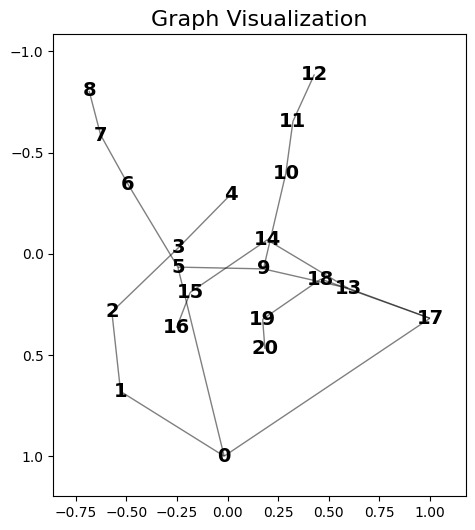

In [35]:
from sklearn.decomposition import PCA

def visualize_single_graph(node_features, edge_index, title="Graph Visualization"):
    node_features, edge_index = node_features.numpy(), edge_index.numpy()
    
    # Apply PCA if node_features has more than 3 dimensions
    if node_features.shape[1] > 3:
        pca = PCA(n_components=3)
        node_features_3d = pca.fit_transform(node_features)
    else:
        node_features_3d = node_features
        
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title, fontsize=16)

    # Extract x and y coordinates from node features
    x = node_features_3d[:, 0]
    y = node_features_3d[:, 1]

    # Create a NetworkX graph and add edges
    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    # Define positions for each node
    pos = {i: (x[i], y[i]) for i in range(len(x))}

    # Plot nodes and edges
#     nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)
    
    # Add node labels (node indices)
    labels = {i: str(i) for i in range(len(x))}
    nx.draw_networkx_labels(G, pos, labels, font_size=14, font_weight="bold", font_color="black", ax=ax)

    # Invert the y-axis for visual consistency and set equal aspect ratio
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    # Remove axis tick labels for a cleaner display
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.show()

visualize_single_graph(dataset[0].x, dataset[0].edge_index)

In [36]:
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

# Split lengths for train (80%), test (10%), valid (10%)
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for step, data in enumerate(train_loader):
    if step < 3:
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()
    else:
        break

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 2], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 2], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 2], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])



In [37]:
from typing import Literal
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch_geometric.nn import global_mean_pool

class MyGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyGCNConv, self).__init__()
        
        self.conv = GCNConv(in_channels, out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.relu(x)
        return x
    
class MyGATConv(nn.Module):
    def __init__(self, in_channels, out_channels, attention_heads=4):
        super(MyGATConv, self).__init__()
        
        assert out_channels % attention_heads == 0
        
        self.conv = GATConv(in_channels, out_channels//attention_heads, heads=attention_heads, concat=True)
        self.combine_heads = nn.Linear(out_channels, out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.combine_heads(x)
        x = self.relu(x)
        return x
    
class MyGATv2Conv(MyGATConv):
    def __init__(self, in_channels, out_channels, attention_heads):
        super(MyGATv2Conv, self).__init__(in_channels, out_channels, attention_heads)
        
        # Replace the GATConv layer with GATv2Conv
        self.conv = GATv2Conv(in_channels, out_channels // attention_heads, heads=attention_heads, concat=True)

class GNN(nn.Module):
    def __init__(self, num_layers, hidden_dim, ff_dim, layer_type: Literal["gcn", "gat"]):
        super(GNN, self).__init__()
        
        assert num_layers >= 1
        
        # GCN
        GNNConvLayer = MyGCNConv if layer_type == "gcn" else MyGATConv
        conv_layers = []
        conv_layers.append(GNNConvLayer(dataset.num_node_features, hidden_dim if num_layers != 1 else ff_dim))
        for i in range(1, num_layers):
            conv_layers.append(GNNConvLayer(hidden_dim, hidden_dim if i != num_layers-1 else ff_dim))
        self.graph_conv = nn.ModuleList(conv_layers)
        
        # Readout
        self.lin = Linear(ff_dim, dataset.num_classes)
        
    def compute_embeddings(self, x, edge_index, batch):
        """Separate this step for visualization purposes."""
        # 1. Obtain node embeddings
        for layer in self.graph_conv:
            x = layer(x, edge_index)
        return x

    def forward(self, x, edge_index, batch):
        x = self.compute_embeddings(x, edge_index, batch)
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x

In [92]:
# model = GNN(num_layers=2, hidden_dim=32, ff_dim=48, layer_type="gat")
# print(model)
# for data in train_loader:
#     print(model(data.x, data.edge_index, data.batch))
#     break

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(loader, optimizer, criterion):
    epoch_loss = 0.0
    
    model.train()
    for data in loader:
        x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
        optimizer.zero_grad()
        out = model(x, edge_index, batch)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() # avg for batch

    avg_loss = epoch_loss / len(loader)
    return avg_loss

def evaluate(loader, optimizer, criterion):
    model.eval()
    epoch_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            out = model(x, edge_index, batch)
            loss = criterion(out, y)
            
            epoch_loss += loss.item()

            # Calculate accuracy
            pred = out.argmax(dim=1)
            correct += int((pred == y).sum())

    avg_loss = epoch_loss / len(loader)
    accuracy = correct / len(loader.dataset)

    return avg_loss, accuracy

VISUALIZE = False
for size_name, model_size in zip(["large"], [128]):
    for num_of_layers in [3]:
        for model_type in ["gat", "gcn"]:
            configuration = f"{size_name}_{model_type}_layer_num_{num_of_layers}"
            
            print()
            print("#"*40)
            print(f"Evaluating: {configuration}")
            print("#"*40)
            print()
            
            model = GNN(num_layers=num_of_layers, hidden_dim=model_size, ff_dim=model_size, layer_type=model_type)
            model.to(device)
            
            optimizer = torch.optim.Adam(model.parameters())
            criterion = torch.nn.CrossEntropyLoss()

            graph_data = []
            EPOCHS = 100
            for epoch in range(1, EPOCHS+1):
                train_loss = train(train_loader, optimizer, criterion)
                val_loss, val_acc = evaluate(valid_loader, optimizer, criterion)
                test_loss, test_acc = evaluate(test_loader, optimizer, criterion)

                graph_data.append({
                    'epoch': epoch,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                    'test_loss': test_loss,
                    'test_acc': test_acc,
                })

                print(graph_data[-1])
                
                graph_df = pd.DataFrame(graph_data)
                graph_df.to_csv(f"{configuration}.csv", index=False)
                
                if VISUALIZE and epoch % 10 == 0:
                    # Visualize graph embeddings
                    model.eval()
                    with torch.no_grad():
                        x = dataset[0].x.to(device)
                        edge_index = dataset[0].edge_index.to(device)
                        batch = torch.zeros(len(x), dtype=torch.int64).to(device)
                        out = model.compute_embeddings(x, edge_index, batch)
                        visualize_single_graph(out.cpu(), edge_index.cpu())



########################################
Evaluating: large_gat_layer_num_3
########################################

{'epoch': 1, 'train_loss': 1.9146860208634142, 'val_loss': 1.0945857028166452, 'val_acc': 0.6932078009414929, 'test_loss': 1.1062803486982982, 'test_acc': 0.681726502622025}
{'epoch': 2, 'train_loss': 0.9922898677797276, 'val_loss': 0.6556690812110901, 'val_acc': 0.8356422326832549, 'test_loss': 0.6810017118851344, 'test_acc': 0.8233158531665994}
{'epoch': 3, 'train_loss': 0.6651771333340412, 'val_loss': 0.4978454798460007, 'val_acc': 0.8683254875588433, 'test_loss': 0.5340413381656011, 'test_acc': 0.8606965174129353}
{'epoch': 4, 'train_loss': 0.5437330589529782, 'val_loss': 0.4338688485324383, 'val_acc': 0.8847343644922663, 'test_loss': 0.46768884857495624, 'test_acc': 0.8750840392631437}
{'epoch': 5, 'train_loss': 0.4522367654440229, 'val_loss': 0.3390921822438637, 'val_acc': 0.91271015467384, 'test_loss': 0.3760308067003886, 'test_acc': 0.9025144547532608}
{'epoch':

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_embeddings(embeddings, labels, method='tsne', title="Embedding Clusters", n_components=2):
    """
    Plots high-dimensional embeddings as a 2D or 3D scatter plot using dimensionality reduction.

    Parameters:
    - embeddings (np.ndarray): Array of shape (n_samples, n_features).
    - labels (list or np.ndarray): List of labels or classifications for coloring the clusters.
    - method (str): Method for dimensionality reduction ('tsne' or 'pca').
    - title (str): Title of the plot.
    - n_components (int): Number of dimensions to reduce to (2 or 3 for visualization).

    Returns:
    - None, displays the plot.
    """
    # Choose reduction method
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=0)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'pca'.")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    
    # Create plot
    fig = plt.figure()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], 
                             c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
    else:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                             c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
    
    # Add legend and title
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    if n_components == 3:
        ax.set_zlabel("Dimension 3")
    
    plt.show()

In [ ]:
# Accuracies
model_data_acc = {
    "GCN": {
        "layers": {
            1: {"small": 60, "medium": 66.18, "large": 70.49},
            2: {"small": 81.07, "medium": 84.07, "large": 86.89},
            3: {"small": 83.9, "medium": 88.37, "large": 90.53}
        }
    },
    "GAT": {
        "layers": {
            1: {"small": 82.21, "medium": 89.16, "large": 91.53},
            2: {"small": 92.07, "medium": 94.76, "large": 95.9},
            3: {"small": 92.55, "medium": 95.11, "large": 96.58}
        }
    }
}

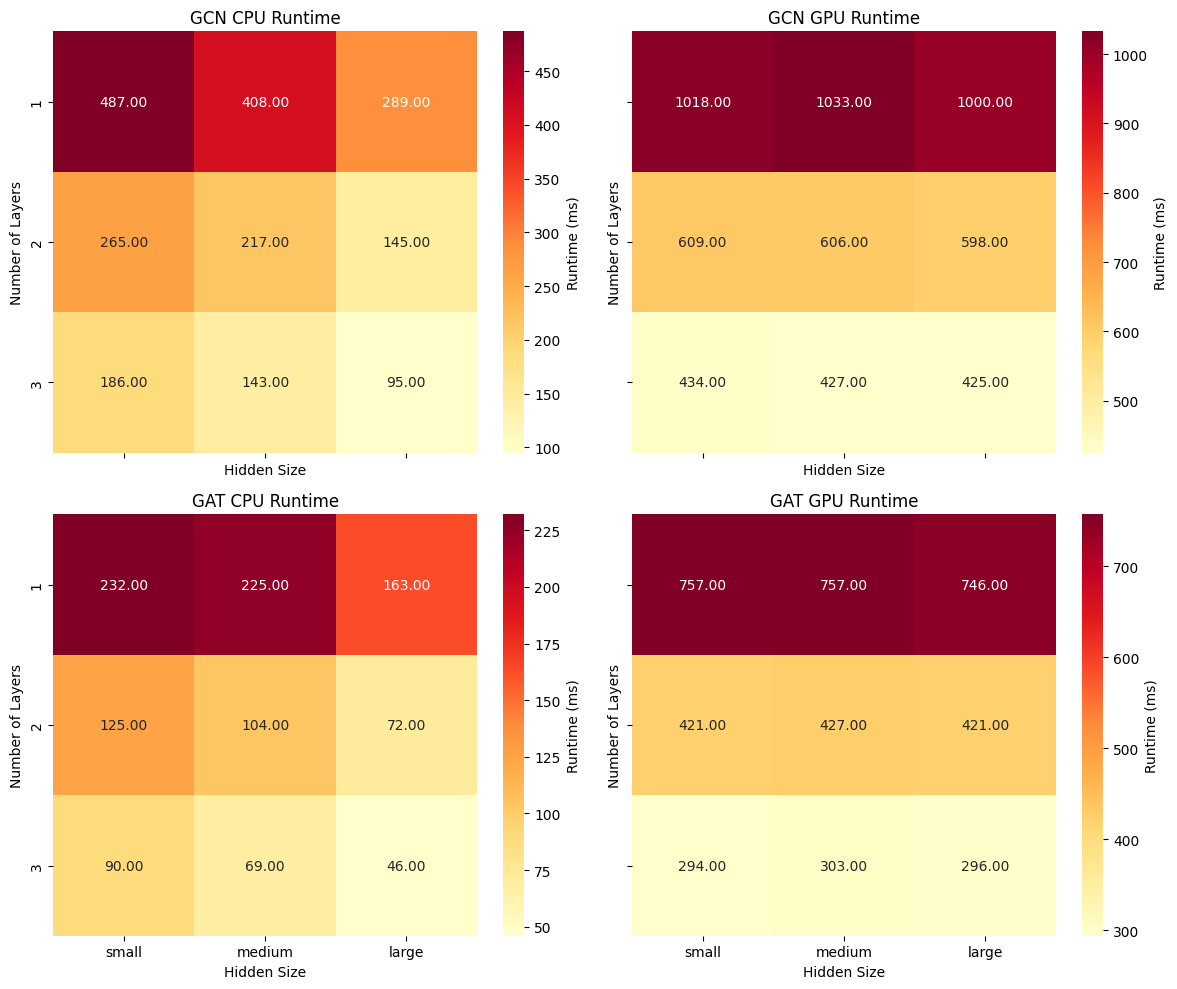

In [51]:
# for device in ["cpu", "cuda"]:
#     print(device)
#     for size_name, model_size in zip(["small", "medium", "large"], [32, 64, 128]):
#         for num_of_layers in [1, 2, 3]:
#             for model_type in ["gcn", "gat"]:
#                 configuration = f"{size_name}_{model_type}_layer_num_{num_of_layers}"
#                 model = GNN(num_layers=num_of_layers, hidden_dim=model_size, ff_dim=model_size, layer_type=model_type)
#                 model.to(device)
#                 for data in train_loader:
#                     print(f"Evaluating: {configuration} ", end="")
#                     x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
#                     %timeit model(x, edge_index, batch)
#                     break

model_data_rt = {
    "GCN": {
        "layers": {
            1: {
                "small": {"cpu": 2.05, "gpu": 0.982},
                "medium": {"cpu": 2.45, "gpu": 0.968},
                "large": {"cpu": 3.45, "gpu": 1},
            },
            2: {
                "small": {"cpu": 3.76, "gpu": 1.64},
                "medium": {"cpu": 4.59, "gpu": 1.65},
                "large": {"cpu": 6.86, "gpu": 1.67},
            },
            3: {
                "small": {"cpu": 5.37, "gpu": 2.3},
                "medium": {"cpu": 6.98, "gpu": 2.34},
                "large": {"cpu": 10.5, "gpu": 2.35},
            },
        }
    },
    "GAT": {
        "layers": {
            1: {
                "small": {"cpu": 4.3, "gpu": 1.32},
                "medium": {"cpu": 4.44, "gpu": 1.32},
                "large": {"cpu": 6.11, "gpu": 1.34},
            },
            2: {
                "small": {"cpu": 7.98, "gpu": 2.37},
                "medium": {"cpu": 9.59, "gpu": 2.34},
                "large": {"cpu": 13.7, "gpu": 2.37},
            },
            3: {
                "small": {"cpu": 11, "gpu": 3.39},
                "medium": {"cpu": 14.4, "gpu": 3.3},
                "large": {"cpu": 21.3, "gpu": 3.37},
            },
        }
    },
}

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_heatmap_data(model_data, model, device):
    # Get heatmap data for the selected model and device (CPU or GPU)
    layers = sorted(model_data[model]["layers"].keys())
    sizes = ["small", "medium", "large"]
    
    heatmap_data = []
    for layer in layers:
        row = [model_data[model]["layers"][layer][size][device] for size in sizes]
        heatmap_data.append(row)
        
    return np.array(heatmap_data), layers, sizes

# Plot heatmaps for both CPU and GPU runtimes for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for i, model in enumerate(["GCN", "GAT"]):
    for j, device in enumerate(["cpu", "gpu"]):
        data, layers, sizes = create_heatmap_data(model_data_rt, model, device)
        
        ax = axes[i, j]
        sns.heatmap(data, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax,
                    xticklabels=sizes, yticklabels=layers, cbar_kws={'label': 'Runtime (ms)'})
        
        ax.set_title(f"{model} {device.upper()} Runtime")
        ax.set_xlabel("Hidden Size")
        ax.set_ylabel("Number of Layers")

plt.tight_layout()
plt.savefig("Mean Runtime Over 7x100 iterations.png", dpi=300)
plt.show()

In [53]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   4
  On-line CPU(s) list:    0-3
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   2
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.28
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [54]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d4f8326b-e8c6-722b-94a8-0bedb128ab8b)


# Regular NN

In [305]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

class StaticASLFingerspellingDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        """
        Args:
            df (pd.DataFrame): DataFrame where the last column is the label.
        """
        processed_features = preprocess_features(df.iloc[:, :-1].values.astype(np.float32))
        processed_features = df.iloc[:, :-1].values.astype(np.float32)
        self.features = torch.tensor(processed_features, dtype=torch.float32)  # Convert features to tensors

        self.label_encoder = LabelEncoder()
        labels = self.label_encoder.fit_transform(df.iloc[:, -1])
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    @property
    def num_classes(self):
        return len(set(self.label_encoder.classes_))
    
dataset = StaticASLFingerspellingDataset(df)
dataset[0]

(tensor([ 5.1672e-01,  8.9821e-01,  2.3889e-06,  3.1378e-01,  7.7277e-01,
         -3.3415e-02,  2.9673e-01,  6.1868e-01, -6.3025e-02,  4.2808e-01,
          4.9351e-01, -1.2143e-01,  5.2918e-01,  3.9163e-01, -1.7835e-01,
          4.2606e-01,  5.3200e-01,  2.6635e-02,  3.2824e-01,  3.7130e-01,
         -6.9805e-02,  2.7471e-01,  2.7606e-01, -1.1622e-01,  2.5221e-01,
          1.9068e-01, -1.3856e-01,  5.9372e-01,  5.3543e-01, -3.9040e-02,
          6.3751e-01,  3.5046e-01, -1.7180e-01,  6.5143e-01,  2.4964e-01,
         -2.4515e-01,  6.9346e-01,  1.5869e-01, -2.6492e-01,  7.5913e-01,
          5.7277e-01, -1.1627e-01,  6.0100e-01,  4.7925e-01, -3.1168e-01,
          4.5024e-01,  5.8092e-01, -3.1352e-01,  4.2338e-01,  6.4953e-01,
         -2.4663e-01,  9.1975e-01,  6.3109e-01, -1.9332e-01,  7.0618e-01,
          5.5511e-01, -3.1331e-01,  5.9209e-01,  6.3303e-01, -2.6347e-01,
          5.9658e-01,  6.9046e-01, -1.8961e-01]),
 tensor(9))

In [306]:
num_classes = dataset.num_classes
num_classes

23

In [307]:
from torch.utils.data import random_split, DataLoader

# Split lengths for train (80%), test (10%), valid (10%)
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [308]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.05):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.silu(self.fc1(x))  # swish activation
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.silu(self.fc3(x))  # swish activation
        x = F.softmax(self.fc4(x), dim=1)
        return x

model = MLP(input_dim=63, output_dim=num_classes)
model

MLP(
  (fc1): Linear(in_features=63, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (fc3): Linear(in_features=128, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=23, bias=True)
)

In [309]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

def train(loader):
    total_loss = 0.0
    model.train()
    for x, y in loader:
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(loader)

def evaluate(loader):
    correct = 0
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            
            loss = criterion(out, y)
            total_loss += loss.item()
            
            pred = out.argmax(dim=1)
            correct += int((pred == y).sum())
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
            
    return avg_loss, accuracy

mlp_data = []
EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    train_loss = train(train_loader)
    val_loss, val_acc = evaluate(valid_loader)
    test_loss, test_acc = evaluate(test_loader)
    
    mlp_data.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'test_loss': test_loss,
        'test_acc': test_acc,
    })
    
    print(mlp_data[-1])

{'epoch': 1, 'train_loss': 2.9989982029910762, 'val_loss': 2.828360589345296, 'val_acc': 0.4049764626765299, 'test_loss': 2.8424771944681804, 'test_acc': 0.39774102460669625}
{'epoch': 2, 'train_loss': 2.7992730376034847, 'val_loss': 2.7712780872980756, 'val_acc': 0.4476126429051782, 'test_loss': 2.7789520343144734, 'test_acc': 0.4400968132311416}
{'epoch': 3, 'train_loss': 2.769273586027612, 'val_loss': 2.7563790559768675, 'val_acc': 0.45501008742434434, 'test_loss': 2.7646631399790444, 'test_acc': 0.44762673120882074}
{'epoch': 4, 'train_loss': 2.7313849987390215, 'val_loss': 2.7052597522735597, 'val_acc': 0.5065232010759919, 'test_loss': 2.7095210552215576, 'test_acc': 0.5016807852628749}
{'epoch': 5, 'train_loss': 2.7063968703470516, 'val_loss': 2.691341495513916, 'val_acc': 0.5237390719569603, 'test_loss': 2.6922356605529787, 'test_acc': 0.5194298776388329}
{'epoch': 6, 'train_loss': 2.680532847351271, 'val_loss': 2.67276615301768, 'val_acc': 0.5404169468728984, 'test_loss': 2.671

In [310]:
mlp_df = pd.DataFrame(mlp_data)
mlp_df.to_csv("final_no_preproc_mlp.csv", index=False)
mlp_df.head()

,epoch,train_loss,val_loss,val_acc,test_loss,test_acc
0,1,2.998998,2.828361,0.404976,2.842477,0.397741
1,2,2.799273,2.771278,0.447613,2.778952,0.440097
2,3,2.769274,2.756379,0.455010,2.764663,0.447627
3,4,2.731385,2.705260,0.506523,2.709521,0.501681
4,5,2.706397,2.691341,0.523739,2.692236,0.519430


In [113]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_runs(df1, df2, col_name, label1='Run 1', label2='Run 2'):
    plt.figure(figsize=(16, 10))
    
    plt.plot(df1['epoch'], df1[col_name],  label=label1, linewidth=3.0)
    plt.plot(df2['epoch'], df2[col_name], label=label2, linewidth=3.0)


    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.xticks(range(0, df1['epoch'].values[-1]+1, 5))
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
compare_runs(mlp_df, graph_df, "val_acc", "MLP", "GNN")

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compare_runs(df1, df2, col_name, label1='Run 1', label2='Run 2'):
    plt.figure(figsize=(16, 5))
    
    # Use a color palette
    sns.set_palette("muted")
    
    # Plot both runs with different line styles
    plt.plot(df1['epoch'], df1[col_name], label=label1, linestyle='-', linewidth=3.0, marker='o', markersize=6)
    plt.plot(df2['epoch'], df2[col_name], label=label2, linestyle='-', linewidth=3.0, marker='s', markersize=6)
    
    # Add titles and labels
    #plt.title(f'Validation Accuracy Comparison\n{label1} vs. {label2}', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Validation Accuracy', fontsize=14)
    
    # Mark max points for each run
    max_df1 = df1[col_name].idxmax()
    max_df2 = df2[col_name].idxmax()
    plt.scatter(df1['epoch'][max_df1], df1[col_name].max(), color='blue', s=20, zorder=5)
    plt.scatter(df2['epoch'][max_df2], df2[col_name].max(), color='orange', s=20, zorder=5)
    
    fs = 16
    plt.text(df1['epoch'][max_df1], df1[col_name].max(), f'{label1} Max: {df1[col_name].max():.4f}', 
             ha='right', va='bottom', color='black', weight='bold', fontsize=fs)
    plt.text(df2['epoch'][max_df2], df2[col_name].max(), f'{label2} Max: {df2[col_name].max():.4f}', 
             ha='right', va='bottom', color='black', weight='bold', fontsize=fs)
    
    # Optional: Add vertical lines at max epochs
    plt.axvline(x=df1['epoch'][max_df1], color='blue', linestyle=':', linewidth=1.5)
    plt.axvline(x=df2['epoch'][max_df2], color='orange', linestyle=':', linewidth=1.5)
    
    # Adjust x-ticks for readability
    plt.xticks(range(0, df1['epoch'].values[-1] + 1, 5))
    
    # Add legend and grid
    plt.legend(fontsize=16, loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 1, 1.3])
    
    # Show plot
    plt.show()


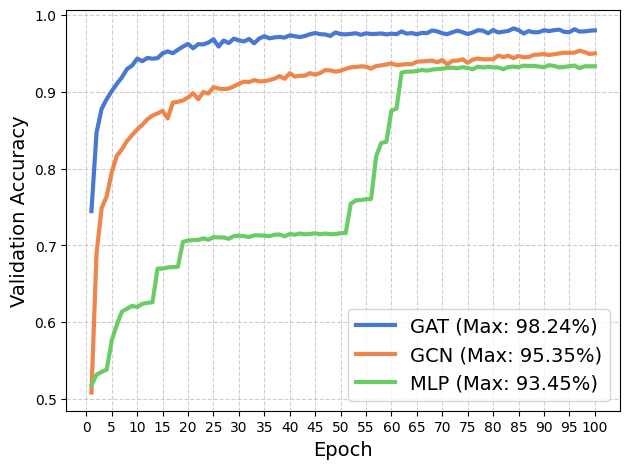

In [296]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# df1 = mlp_df
# df2 = gat_df
# df3 = gcn_df
# col_name = "val_acc"

# # plt.figure(figsize=(10, 5))

# # Use a color palette
# sns.set_palette("muted")

# # Calculate max values
# max_val_mlp = df1[col_name].max()
# max_val_gat = df2[col_name].max()
# max_val_gcn = df3[col_name].max()

# # Plot all three runs with max values in the legend
# plt.plot(df2['epoch'], df2[col_name], label=f"GAT (Max: {100*max_val_gat:.2f}%)", linestyle='-', linewidth=3.0, )
# plt.plot(df3['epoch'], df3[col_name], label=f"GCN (Max: {100*max_val_gcn:.2f}%)", linestyle='-', linewidth=3.0, )
# plt.plot(df1['epoch'], df1[col_name], label=f"MLP (Max: {100*max_val_mlp:.2f}%)", linestyle='-', linewidth=3.0, )

# # Add axis labels
# plt.xlabel('Epoch', fontsize=14)
# plt.ylabel('Validation Accuracy', fontsize=14)

# # Mark max points for each run and add vertical lines
# max_df1 = df1[col_name].idxmax()
# max_df2 = df2[col_name].idxmax()
# max_df3 = df3[col_name].idxmax()

# # Define colors
# orange = (238/255, 133/255, 74/255)
# green = (106/255, 200/255, 100/255)
# blue = (72/255, 120/255, 208/255)

# # Plot scatter points for max values
# # plt.scatter(df1['epoch'][max_df1], max_val_mlp, color=blue, s=40, zorder=5)
# # plt.scatter(df2['epoch'][max_df2], max_val_gat, color=orange, s=40, zorder=5)
# # plt.scatter(df3['epoch'][max_df3], max_val_gcn, color=green, s=40, zorder=5)

# # Add vertical lines at max epochs
# # plt.axvline(x=df1['epoch'][max_df1], color=blue, linestyle=':', linewidth=3)
# # plt.axvline(x=df2['epoch'][max_df2], color=orange, linestyle=':', linewidth=3)
# # plt.axvline(x=df3['epoch'][max_df3], color=green, linestyle=':', linewidth=3)

# # Adjust x-ticks for readability
# plt.xticks(range(0, df1['epoch'].values[-1] + 1, 5))
# #plt.ylim(0.5, 1.02)

# # Add legend and grid
# plt.legend(fontsize=14, loc='lower right')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()

# # Show plot
# plt.savefig("valid_run.png", dpi=300)
# plt.show()